# Sprint 機械学習スクラッチ　ロジスティック回帰

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

ロジスティック回帰のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

以下に雛形を用意してあります。このScratchLogisticRegressionクラスにコードを書き加えていってください。推定関係のメソッドは線形回帰と異なり、ラベルを出力するpredictメソッドと、確率を出力するpredict_probaメソッドの2種類を作成します。

In [7]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      学習用データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証用データに対する損失の記録

    """

    def __init__(self, num_iter, lr, lam, bias=None, verbose=None):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.lam = lam
        self.bias = bias
        self.verbose = verbose
        # パラメーターと予測値の初期化
        self.coef_ = 0
        self.h0 = 0
        self.h0_val = 0
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter+1)
        self.val_loss = np.zeros(self.iter+1)
        # yのカテゴリ最大値、最小値の初期化
        self.y_max = 0
        self.y_min = 0

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """

        # yの一次元化
        y = y.ravel()
        y_val = y_val.ravel()
        
        # yのカテゴリ最大値、最小値を取得
        self.y_max = y.max()
        self.y_min = y.min()
        # yの０、１化(今回の題材は最大３分類のため、それに対応)
        if y.max()==2:
            y = np.where(y==2, 1, 0)
            y_val = np.where(y_val==2, 1, 0)
        
        # 切片列を追加（切片の有無を選べる）
        if not self.bias:   
            X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=1)
            X_val = np.concatenate([np.ones([X_val.shape[0], 1]), X_val], axis=1)
        
        #パラメーターの設定（平均０、分散１の正規分布）
        self.coef_ = np.random.normal(0, 1, X.shape[1])
        
        for iter_count in range(self.iter):
            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                print("{}回目の学習".format(iter_count))
            
            # 過程関数、valも同時に更新
            _logistic_hypothesis(self, X, X_val)
            
            # lossの記録（初期値〜最後の更新前まで）
            loss_cal(self, iter_count, y, y_val)
            
            # 最急降下法
            # self.coef_の更新
            _gradient_descent(self, X, y, iter_count)
        
        # 最終的なlossを記録
        loss_cal(self, self.iter, y, y_val)

        return
    

    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        # カテゴリ最大値、最小値に対応させるために分岐
        if self.y_max == 2:
            if self.y_min == 1:
                return np.where(self.predict_proba(X)<0.5, 1, 2)
            else:
                return np.where(self.predict_proba(X)<0.5, 0, 2)
        else:
            return  np.where(self.predict_proba(X)<0.5, 0, 1)
        
        
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
        h : 次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        # バイアスあり
        if not self.bias:
            X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=1)
            h_liine = np.dot(X, self.coef_.T)
            h = 1 / (1+np.exp(-h_liine))
        
        # バイアスなし
        else:
            h_liine = np.dot(X, self.coef_.T)
            h = 1 / (1+np.exp(-h_liine))

        return h

# 【問題1】仮定関数
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。

ロジスティック回帰の仮定関数は、線形回帰の仮定関数を シグモイド関数 に通したものです。シグモイド関数は以下の式で表されます。

In [8]:
def _logistic_hypothesis(self, X, X_val=None):
    """
    線形の仮定関数を計算する

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
      
    h_line : 次の形のndarray, shape (n_samples)
      trainの線型結合 
      
    h_line_val : 次の形のndarray, shape (n_samples)
      valの線型結合 
    
    Attributes
    ----------
      
    self.coef_ : 次の形のndarray, shape (n_features)
      Xに対するパラメーター 
    
    self.h0 : 次の形のndarray, shape (n_samples)
      シグモイド関数によるtrainの予測値（過程関数）
      
    self.h0_val : 次の形のndarray, shape (n_samples)
      シグモイド関数によるvalの予測値（過程関数）

    """
    # Xの過程関数
    # 線型結合
    h_liine = np.dot(X, self.coef_.T)
    # シグモイド関数化
    self.h0 = 1 / (1+np.exp(-h_liine))
    
    
    # X_valの過程関数
    # 線型結合
    h_liine_val = np.dot(X_val, self.coef_.T)
    # シグモイド関数化
    self.h0_val = 1 / (1+np.exp(-h_liine_val))
    
    return

# 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。

In [9]:
def _gradient_descent(self, X, y, iter_count):
    """
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    
    y : 次の形のndarray, shape (n_samples)
      学習データの結果
      
    self.lam : float
      正則化パラメータ
      
    self.lr : float
      学習率
    
    self.coef_ : 次の形のndarray, shape (n_features)
      Xに対するパラメーター
      
    coef_reg : 次の形のndarray, shape (n_features)
      正則化に用いるパラメーター
    
    self.h0 : 次の形のndarray, shape (n_samples)
      シグモイド関数によるtrainの予測値（過程関数）
    
    Returns
    -------
    self.theta_ : 次の形のndarray, shape (n_samples, 1)
      線形の仮定関数による推定結果
      
    """
    # 傾き、j=0,1で正則化の有無が異なる
    # そのため、正則化項のcoef_[0]を０にする
    coef_reg = self.coef_.copy()
    coef_reg[0] = 0
    delta = (np.dot(X.T, (self.h0 - y)) + self.lam*coef_reg)/X.shape[0]
    
    # 更新式
    self.coef_ = self.coef_ - self.lr*delta
    
    return

 # 【問題3】推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。

仮定関数 hθ(x) の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。

# 【問題4】目的関数
以下の数式で表されるロジスティック回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。

なお、この数式には正則化項が含まれています。

＊数式が見切れる場合、DIVERを全画面にして御覧ください。

In [10]:
def loss_cal(self, iter_count, y, y_val=None):
    """
    損失関数の計算と記録

    Parameters
    ----------
    y_pred : 次の形のndarray, shape (n_samples,)
      推定した値
    y : 次の形のndarray, shape (n_samples,)
      正解値

    Returns
    ----------
    cost : numpy.float
      平均二乗誤差
    """
    # 傾き、j=0,1で正則化の有無が異なる
    # そのため、正則化項のcoef_[0]を０にする
    coef_reg = self.coef_.copy()
    coef_reg[0] = 0
    
    #logないがゼロにならないようにする
    epsilon = 1e-5
    
    #trainのloss
    loss = ((-y * np.log(self.h0+epsilon) -
               (1-y) * np.log(1-self.h0+epsilon)).sum() +
               self.lam/2*(coef_reg**2).sum()) / y.shape[0]
    self.loss[iter_count] = loss
    
    #valのloss
    val_loss = ((-y_val * np.log(self.h0_val+epsilon) -
                    (1-y_val) * np.log(1-self.h0_val+epsilon)).sum() +
                    self.lam/2*(coef_reg**2).sum()) / y.shape[0]
    self.val_loss[iter_count] = val_loss

    return

# 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。

AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [11]:
from sklearn.datasets import load_iris
iris = load_iris()
X = pd.DataFrame(data=iris.data, columns=iris.feature_names)
y = pd.DataFrame(data=iris.target, columns=['species'])
df = pd.concat([X, y], axis=1)
# 抜き出し
df_2ex =df.query('species == 1 | species == 2')[["sepal length (cm)", "petal length (cm)", 'species']]
X = df_2ex[["sepal length (cm)", "petal length (cm)",]]
y = df_2ex[["species"]]
# ndarray変換
X_array = X.values
# yに関して一次元化（グラフ化で必要）
y_array = np.ravel(y.values)
# 分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X_array, y_array, test_size=0.25, random_state=0)
# 標準化
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_valid_std = scaler.transform(X_valid)

In [12]:
# 学習
slreg = ScratchLogisticRegression(5000, 0.005, 0.001)
slreg.fit(X_train_std, y_train, X_valid_std, y_valid)
y_valid_predict = slreg.predict(X_valid_std)

In [13]:
y_valid_predict

array([2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 1, 1])

In [14]:
y_valid

array([1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 2, 1])

In [15]:
# 正解率
print("正解率：", accuracy_score(y_valid, y_valid_predict))
# 適合率
print("適合率：", precision_score(y_valid, y_valid_predict))
# Recall（再現率）
print("再現率：", recall_score(y_valid, y_valid_predict))
# F値
print("F値：", f1_score(y_valid, y_valid_predict))
# 混同行列
print("混同行列\n", confusion_matrix(y_valid, y_valid_predict))

正解率： 0.8
適合率： 0.9
再現率： 0.6923076923076923
F値： 0.7826086956521738
混同行列
 [[ 9  4]
 [ 1 11]]


# 【問題6】学習曲線のプロット
学習曲線を見て損失が適切に下がっているかどうか確認してください。

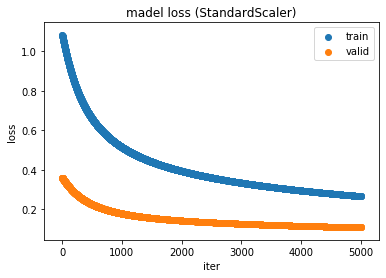

In [16]:
# グラフ化
iter_list = [i for i in range(slreg.iter+1)]
plt.scatter(iter_list, slreg.loss, label="train")
plt.scatter(iter_list, slreg.val_loss, label="valid")
plt.ylabel('loss')
plt.xlabel('iter')
plt.title('madel loss (StandardScaler)')
plt.legend();

# 【問題7】決定領域の可視化
決定領域を可視化してください。

In [17]:
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel',
                    ylabel='ylabel', target_names=['setosa', 'versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['green', 'red', 'blue']
    contourf_color = ['white', 'pink', 'skyblue']
    # クラスの長さをクラス数
    n_class = len(set(y))

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step),
                                    np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # contourf_color、scatter_color、target_namesをクラス数に応じて変化
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap([contourf_color[n] for n in set(y)]))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80,
                    color=scatter_color[target],label=target_names[target], marker='o')
    patches = [mpatches.Patch(color=scatter_color[n], label=target_names[n]) for n in set(y)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

In [32]:
y_train.shape

(75,)

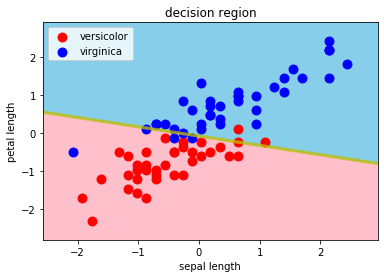

In [18]:
decision_region(X_train_std, y_train, model=slreg, step=0.01, title='decision region',
                xlabel="sepal length", ylabel="petal length")

# 【問題8】（アドバンス課題）重みの保存
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。pickleモジュールやNumPyのnp.savezを利用します。

In [19]:
import pickle
# 保存
with open('sprint3-work1_param.pickle', 'wb') as f:
    pickle.dump(slreg.coef_, f)

In [20]:
# 出力
with open('sprint3-work1_param.pickle', 'rb') as f:
    best_param = pickle.load(f)

In [21]:
# 一致しているか確認
print(best_param == slreg.coef_)

[ True  True  True]


# バイアスなし、学習の記録

In [22]:
# 学習
slreg_no = ScratchLogisticRegression(5000, 0.005, 0.001, True, True)
slreg_no.fit(X_train_std, y_train, X_valid_std, y_valid)
y_valid_predict_no = slreg_no.predict(X_valid_std)

0回目の学習
1回目の学習
2回目の学習
3回目の学習
4回目の学習
5回目の学習
6回目の学習
7回目の学習
8回目の学習
9回目の学習
10回目の学習
11回目の学習
12回目の学習
13回目の学習
14回目の学習
15回目の学習
16回目の学習
17回目の学習
18回目の学習
19回目の学習
20回目の学習
21回目の学習
22回目の学習
23回目の学習
24回目の学習
25回目の学習
26回目の学習
27回目の学習
28回目の学習
29回目の学習
30回目の学習
31回目の学習
32回目の学習
33回目の学習
34回目の学習
35回目の学習
36回目の学習
37回目の学習
38回目の学習
39回目の学習
40回目の学習
41回目の学習
42回目の学習
43回目の学習
44回目の学習
45回目の学習
46回目の学習
47回目の学習
48回目の学習
49回目の学習
50回目の学習
51回目の学習
52回目の学習
53回目の学習
54回目の学習
55回目の学習
56回目の学習
57回目の学習
58回目の学習
59回目の学習
60回目の学習
61回目の学習
62回目の学習
63回目の学習
64回目の学習
65回目の学習
66回目の学習
67回目の学習
68回目の学習
69回目の学習
70回目の学習
71回目の学習
72回目の学習
73回目の学習
74回目の学習
75回目の学習
76回目の学習
77回目の学習
78回目の学習
79回目の学習
80回目の学習
81回目の学習
82回目の学習
83回目の学習
84回目の学習
85回目の学習
86回目の学習
87回目の学習
88回目の学習
89回目の学習
90回目の学習
91回目の学習
92回目の学習
93回目の学習
94回目の学習
95回目の学習
96回目の学習
97回目の学習
98回目の学習
99回目の学習
100回目の学習
101回目の学習
102回目の学習
103回目の学習
104回目の学習
105回目の学習
106回目の学習
107回目の学習
108回目の学習
109回目の学習
110回目の学習
111回目の学習
112回目の学習
113回目の学習
114回目の学習
115回目の学習
116回目の学習
117回目の学習
118回目の学習
119回目の学習
120回目の学習
121回目の学習
122回目の学習
123

1733回目の学習
1734回目の学習
1735回目の学習
1736回目の学習
1737回目の学習
1738回目の学習
1739回目の学習
1740回目の学習
1741回目の学習
1742回目の学習
1743回目の学習
1744回目の学習
1745回目の学習
1746回目の学習
1747回目の学習
1748回目の学習
1749回目の学習
1750回目の学習
1751回目の学習
1752回目の学習
1753回目の学習
1754回目の学習
1755回目の学習
1756回目の学習
1757回目の学習
1758回目の学習
1759回目の学習
1760回目の学習
1761回目の学習
1762回目の学習
1763回目の学習
1764回目の学習
1765回目の学習
1766回目の学習
1767回目の学習
1768回目の学習
1769回目の学習
1770回目の学習
1771回目の学習
1772回目の学習
1773回目の学習
1774回目の学習
1775回目の学習
1776回目の学習
1777回目の学習
1778回目の学習
1779回目の学習
1780回目の学習
1781回目の学習
1782回目の学習
1783回目の学習
1784回目の学習
1785回目の学習
1786回目の学習
1787回目の学習
1788回目の学習
1789回目の学習
1790回目の学習
1791回目の学習
1792回目の学習
1793回目の学習
1794回目の学習
1795回目の学習
1796回目の学習
1797回目の学習
1798回目の学習
1799回目の学習
1800回目の学習
1801回目の学習
1802回目の学習
1803回目の学習
1804回目の学習
1805回目の学習
1806回目の学習
1807回目の学習
1808回目の学習
1809回目の学習
1810回目の学習
1811回目の学習
1812回目の学習
1813回目の学習
1814回目の学習
1815回目の学習
1816回目の学習
1817回目の学習
1818回目の学習
1819回目の学習
1820回目の学習
1821回目の学習
1822回目の学習
1823回目の学習
1824回目の学習
1825回目の学習
1826回目の学習
1827回目の学習
1828回目の学習
1829回目の学習
1830回目の学習
1831回目の学習
1832回目の学習


2649回目の学習
2650回目の学習
2651回目の学習
2652回目の学習
2653回目の学習
2654回目の学習
2655回目の学習
2656回目の学習
2657回目の学習
2658回目の学習
2659回目の学習
2660回目の学習
2661回目の学習
2662回目の学習
2663回目の学習
2664回目の学習
2665回目の学習
2666回目の学習
2667回目の学習
2668回目の学習
2669回目の学習
2670回目の学習
2671回目の学習
2672回目の学習
2673回目の学習
2674回目の学習
2675回目の学習
2676回目の学習
2677回目の学習
2678回目の学習
2679回目の学習
2680回目の学習
2681回目の学習
2682回目の学習
2683回目の学習
2684回目の学習
2685回目の学習
2686回目の学習
2687回目の学習
2688回目の学習
2689回目の学習
2690回目の学習
2691回目の学習
2692回目の学習
2693回目の学習
2694回目の学習
2695回目の学習
2696回目の学習
2697回目の学習
2698回目の学習
2699回目の学習
2700回目の学習
2701回目の学習
2702回目の学習
2703回目の学習
2704回目の学習
2705回目の学習
2706回目の学習
2707回目の学習
2708回目の学習
2709回目の学習
2710回目の学習
2711回目の学習
2712回目の学習
2713回目の学習
2714回目の学習
2715回目の学習
2716回目の学習
2717回目の学習
2718回目の学習
2719回目の学習
2720回目の学習
2721回目の学習
2722回目の学習
2723回目の学習
2724回目の学習
2725回目の学習
2726回目の学習
2727回目の学習
2728回目の学習
2729回目の学習
2730回目の学習
2731回目の学習
2732回目の学習
2733回目の学習
2734回目の学習
2735回目の学習
2736回目の学習
2737回目の学習
2738回目の学習
2739回目の学習
2740回目の学習
2741回目の学習
2742回目の学習
2743回目の学習
2744回目の学習
2745回目の学習
2746回目の学習
2747回目の学習
2748回目の学習


3602回目の学習
3603回目の学習
3604回目の学習
3605回目の学習
3606回目の学習
3607回目の学習
3608回目の学習
3609回目の学習
3610回目の学習
3611回目の学習
3612回目の学習
3613回目の学習
3614回目の学習
3615回目の学習
3616回目の学習
3617回目の学習
3618回目の学習
3619回目の学習
3620回目の学習
3621回目の学習
3622回目の学習
3623回目の学習
3624回目の学習
3625回目の学習
3626回目の学習
3627回目の学習
3628回目の学習
3629回目の学習
3630回目の学習
3631回目の学習
3632回目の学習
3633回目の学習
3634回目の学習
3635回目の学習
3636回目の学習
3637回目の学習
3638回目の学習
3639回目の学習
3640回目の学習
3641回目の学習
3642回目の学習
3643回目の学習
3644回目の学習
3645回目の学習
3646回目の学習
3647回目の学習
3648回目の学習
3649回目の学習
3650回目の学習
3651回目の学習
3652回目の学習
3653回目の学習
3654回目の学習
3655回目の学習
3656回目の学習
3657回目の学習
3658回目の学習
3659回目の学習
3660回目の学習
3661回目の学習
3662回目の学習
3663回目の学習
3664回目の学習
3665回目の学習
3666回目の学習
3667回目の学習
3668回目の学習
3669回目の学習
3670回目の学習
3671回目の学習
3672回目の学習
3673回目の学習
3674回目の学習
3675回目の学習
3676回目の学習
3677回目の学習
3678回目の学習
3679回目の学習
3680回目の学習
3681回目の学習
3682回目の学習
3683回目の学習
3684回目の学習
3685回目の学習
3686回目の学習
3687回目の学習
3688回目の学習
3689回目の学習
3690回目の学習
3691回目の学習
3692回目の学習
3693回目の学習
3694回目の学習
3695回目の学習
3696回目の学習
3697回目の学習
3698回目の学習
3699回目の学習
3700回目の学習
3701回目の学習


4450回目の学習
4451回目の学習
4452回目の学習
4453回目の学習
4454回目の学習
4455回目の学習
4456回目の学習
4457回目の学習
4458回目の学習
4459回目の学習
4460回目の学習
4461回目の学習
4462回目の学習
4463回目の学習
4464回目の学習
4465回目の学習
4466回目の学習
4467回目の学習
4468回目の学習
4469回目の学習
4470回目の学習
4471回目の学習
4472回目の学習
4473回目の学習
4474回目の学習
4475回目の学習
4476回目の学習
4477回目の学習
4478回目の学習
4479回目の学習
4480回目の学習
4481回目の学習
4482回目の学習
4483回目の学習
4484回目の学習
4485回目の学習
4486回目の学習
4487回目の学習
4488回目の学習
4489回目の学習
4490回目の学習
4491回目の学習
4492回目の学習
4493回目の学習
4494回目の学習
4495回目の学習
4496回目の学習
4497回目の学習
4498回目の学習
4499回目の学習
4500回目の学習
4501回目の学習
4502回目の学習
4503回目の学習
4504回目の学習
4505回目の学習
4506回目の学習
4507回目の学習
4508回目の学習
4509回目の学習
4510回目の学習
4511回目の学習
4512回目の学習
4513回目の学習
4514回目の学習
4515回目の学習
4516回目の学習
4517回目の学習
4518回目の学習
4519回目の学習
4520回目の学習
4521回目の学習
4522回目の学習
4523回目の学習
4524回目の学習
4525回目の学習
4526回目の学習
4527回目の学習
4528回目の学習
4529回目の学習
4530回目の学習
4531回目の学習
4532回目の学習
4533回目の学習
4534回目の学習
4535回目の学習
4536回目の学習
4537回目の学習
4538回目の学習
4539回目の学習
4540回目の学習
4541回目の学習
4542回目の学習
4543回目の学習
4544回目の学習
4545回目の学習
4546回目の学習
4547回目の学習
4548回目の学習
4549回目の学習


In [23]:
# 正解率
print("正解率：", accuracy_score(y_valid, y_valid_predict_no))
# 適合率
print("適合率：", precision_score(y_valid, y_valid_predict_no))
# Recall（再現率）
print("再現率：", recall_score(y_valid, y_valid_predict_no))
# F値
print("F値：", f1_score(y_valid, y_valid_predict_no))
# 混同行列
print("混同行列\n", confusion_matrix(y_valid, y_valid_predict_no))

正解率： 0.84
適合率： 0.9090909090909091
再現率： 0.7692307692307693
F値： 0.8333333333333333
混同行列
 [[10  3]
 [ 1 11]]


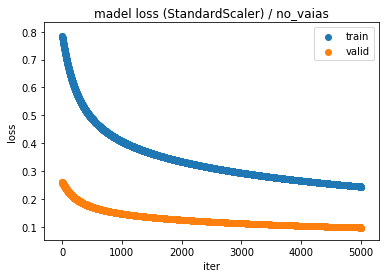

In [24]:
# グラフ化
iter_list_no = [i for i in range(slreg_no.iter+1)]
plt.scatter(iter_list_no, slreg_no.loss, label="train")
plt.scatter(iter_list_no, slreg_no.val_loss, label="valid")
plt.ylabel('loss')
plt.xlabel('iter')
plt.title('madel loss (StandardScaler) / no_vaias')
plt.legend();

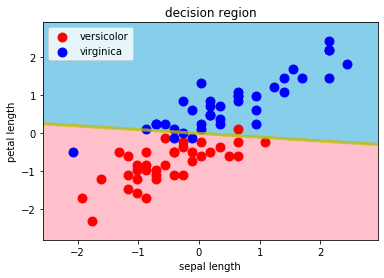

In [25]:
# 境界線の可視化
decision_region(X_train_std, y_train, model=slreg_no, step=0.01, title='decision region',
                xlabel="sepal length", ylabel="petal length")